In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from zuko.flows.autoregressive import MaskedAutoregressiveTransform
from zuko.transforms import (
    MonotonicAffineTransform,
)
from zuko.flows import UnconditionalDistribution
from torch.distributions import Cauchy, Normal, Laplace, Bernoulli, Uniform
import copy
from causal_cocycle.model_new import ZukoCocycleModel
from causal_cocycle.optimise_new import optimise
from causal_cocycle.loss import CocycleLoss
from causal_cocycle.loss_factory import CocycleLossFactory
from causal_cocycle.kernels import gaussian_kernel
from causal_cocycle.ssvkernel import ssvkernel
from scipy.stats import betaprime, norm
import numpy as np
from architectures import get_nsf_transforms, IdentityTransform,DiscreteSelectorTransform

In [2]:
# ── Data ─────────────────────────────────────────────────────
def draw_abs_nbp(size):
    """
    |NBP(0.1,0.1)|  where  NB P  is  Normal–Beta-Prime:
      τ   ~ BetaPrime(0.1, 0.1)
      V|τ ~ N(0, τ)
      return |V|
    """
    τ   = betaprime.rvs(0.1, 0.1, size=size)
    v   = norm.rvs(scale=np.sqrt(τ))
    return np.abs(v)

class MixedTails:

    def __init__(self,):
        return

    def sample(self, size):
        b = Bernoulli(1/2).sample(size)
        u1 = Normal(0,1).sample(size).abs()
        u2 = torch.tensor(draw_abs_nbp(size))
        return u1*b - u2*(1-b)
        
seed = 0
torch.manual_seed(seed)
N_train = 2000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
U = MixedTails().sample((N_train,1)).to(device)
X = torch.cat([torch.ones(N_train //2),torch.zeros(N_train //2)])[:,None]
Y = (X+1)*U

In [3]:
# ── Build loss and transforms ───────────────────────────────
d = 1   # dim(Y)

nsf = get_nsf_transforms()[0][0]

flow0 = IdentityTransform()
discrete_nsf_selector_transform = DiscreteSelectorTransform(nn.ModuleList([IdentityTransform(), nsf]))
model = ZukoCocycleModel(transforms=torch.nn.ModuleList([discrete_nsf_selector_transform]))

kernel = [gaussian_kernel(), gaussian_kernel()]
loss_factory = CocycleLossFactory(kernel)
loss = loss_factory.build_loss("CMMD_V", X, Y)

In [4]:
# Example hyperparameters—feel free to adjust as desired:
learn_rate       = 1e-2
epochs           = 1000
batch_size       = 128

# Finally, run training. We supply both train and val sets so optimise can compute validation loss each epoch:
best_model, history = optimise(
    model            = model,
    loss_tr          = loss,
    inputs           = X,
    outputs          = Y,
    inputs_val       = None,
    outputs_val      = None,
    learn_rate       = learn_rate,
    epochs           = epochs,
    batch_size       = batch_size,
)

Epoch 1/1000, Training Loss: -0.4380
Epoch 2/1000, Training Loss: -0.4476
Epoch 3/1000, Training Loss: -0.4384
Epoch 4/1000, Training Loss: -0.4598
Epoch 5/1000, Training Loss: -0.4303
Epoch 6/1000, Training Loss: -0.4443
Epoch 7/1000, Training Loss: -0.4292
Epoch 8/1000, Training Loss: -0.4592
Epoch 9/1000, Training Loss: -0.4529
Epoch 10/1000, Training Loss: -0.4543
Epoch 11/1000, Training Loss: -0.4508
Epoch 12/1000, Training Loss: -0.4437
Epoch 13/1000, Training Loss: -0.4340
Epoch 14/1000, Training Loss: -0.4429
Epoch 15/1000, Training Loss: -0.4339
Epoch 16/1000, Training Loss: -0.4548
Epoch 17/1000, Training Loss: -0.4244
Epoch 18/1000, Training Loss: -0.4509
Epoch 19/1000, Training Loss: -0.4583
Epoch 20/1000, Training Loss: -0.4398
Epoch 21/1000, Training Loss: -0.4451
Epoch 22/1000, Training Loss: -0.4537
Epoch 23/1000, Training Loss: -0.4440
Epoch 24/1000, Training Loss: -0.4432
Epoch 25/1000, Training Loss: -0.4430
Epoch 26/1000, Training Loss: -0.4683
Epoch 27/1000, Traini

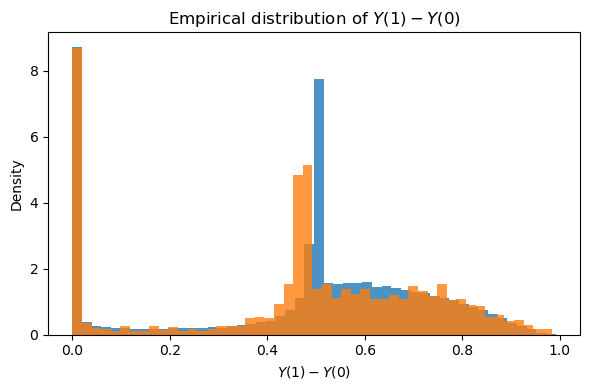

In [5]:
# ── 4) Paired sampling via reseeding ──────────────────────────────────────────
N_effect = 10**5
with torch.no_grad():
    Y0_eff = model.cocycle(X*0+0,X,Y)
    Y1_eff = model.cocycle(X*0+1,X,Y)
delta = (Y1_eff - Y0_eff).squeeze(-1)
Y0 = MixedTails().sample((N_effect,)).to(device)
Y1 = Y0*2
true_delta = Y1-Y0


def t(x):
    #return torch.log(x.abs()+1)*torch.sign(x)
    return torch.sigmoid(x)

# ── 5) Plot empirical histogram of ΔY ────────────────────────────────────────
plt.figure(figsize=(6,4))
plt.hist(t(true_delta), bins=50, density=True, alpha=0.8)
plt.hist(t(delta), bins=50, density=True, alpha=0.8)
plt.title("Empirical distribution of $Y(1)-Y(0)$")
plt.xlabel("$Y(1)-Y(0)$")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

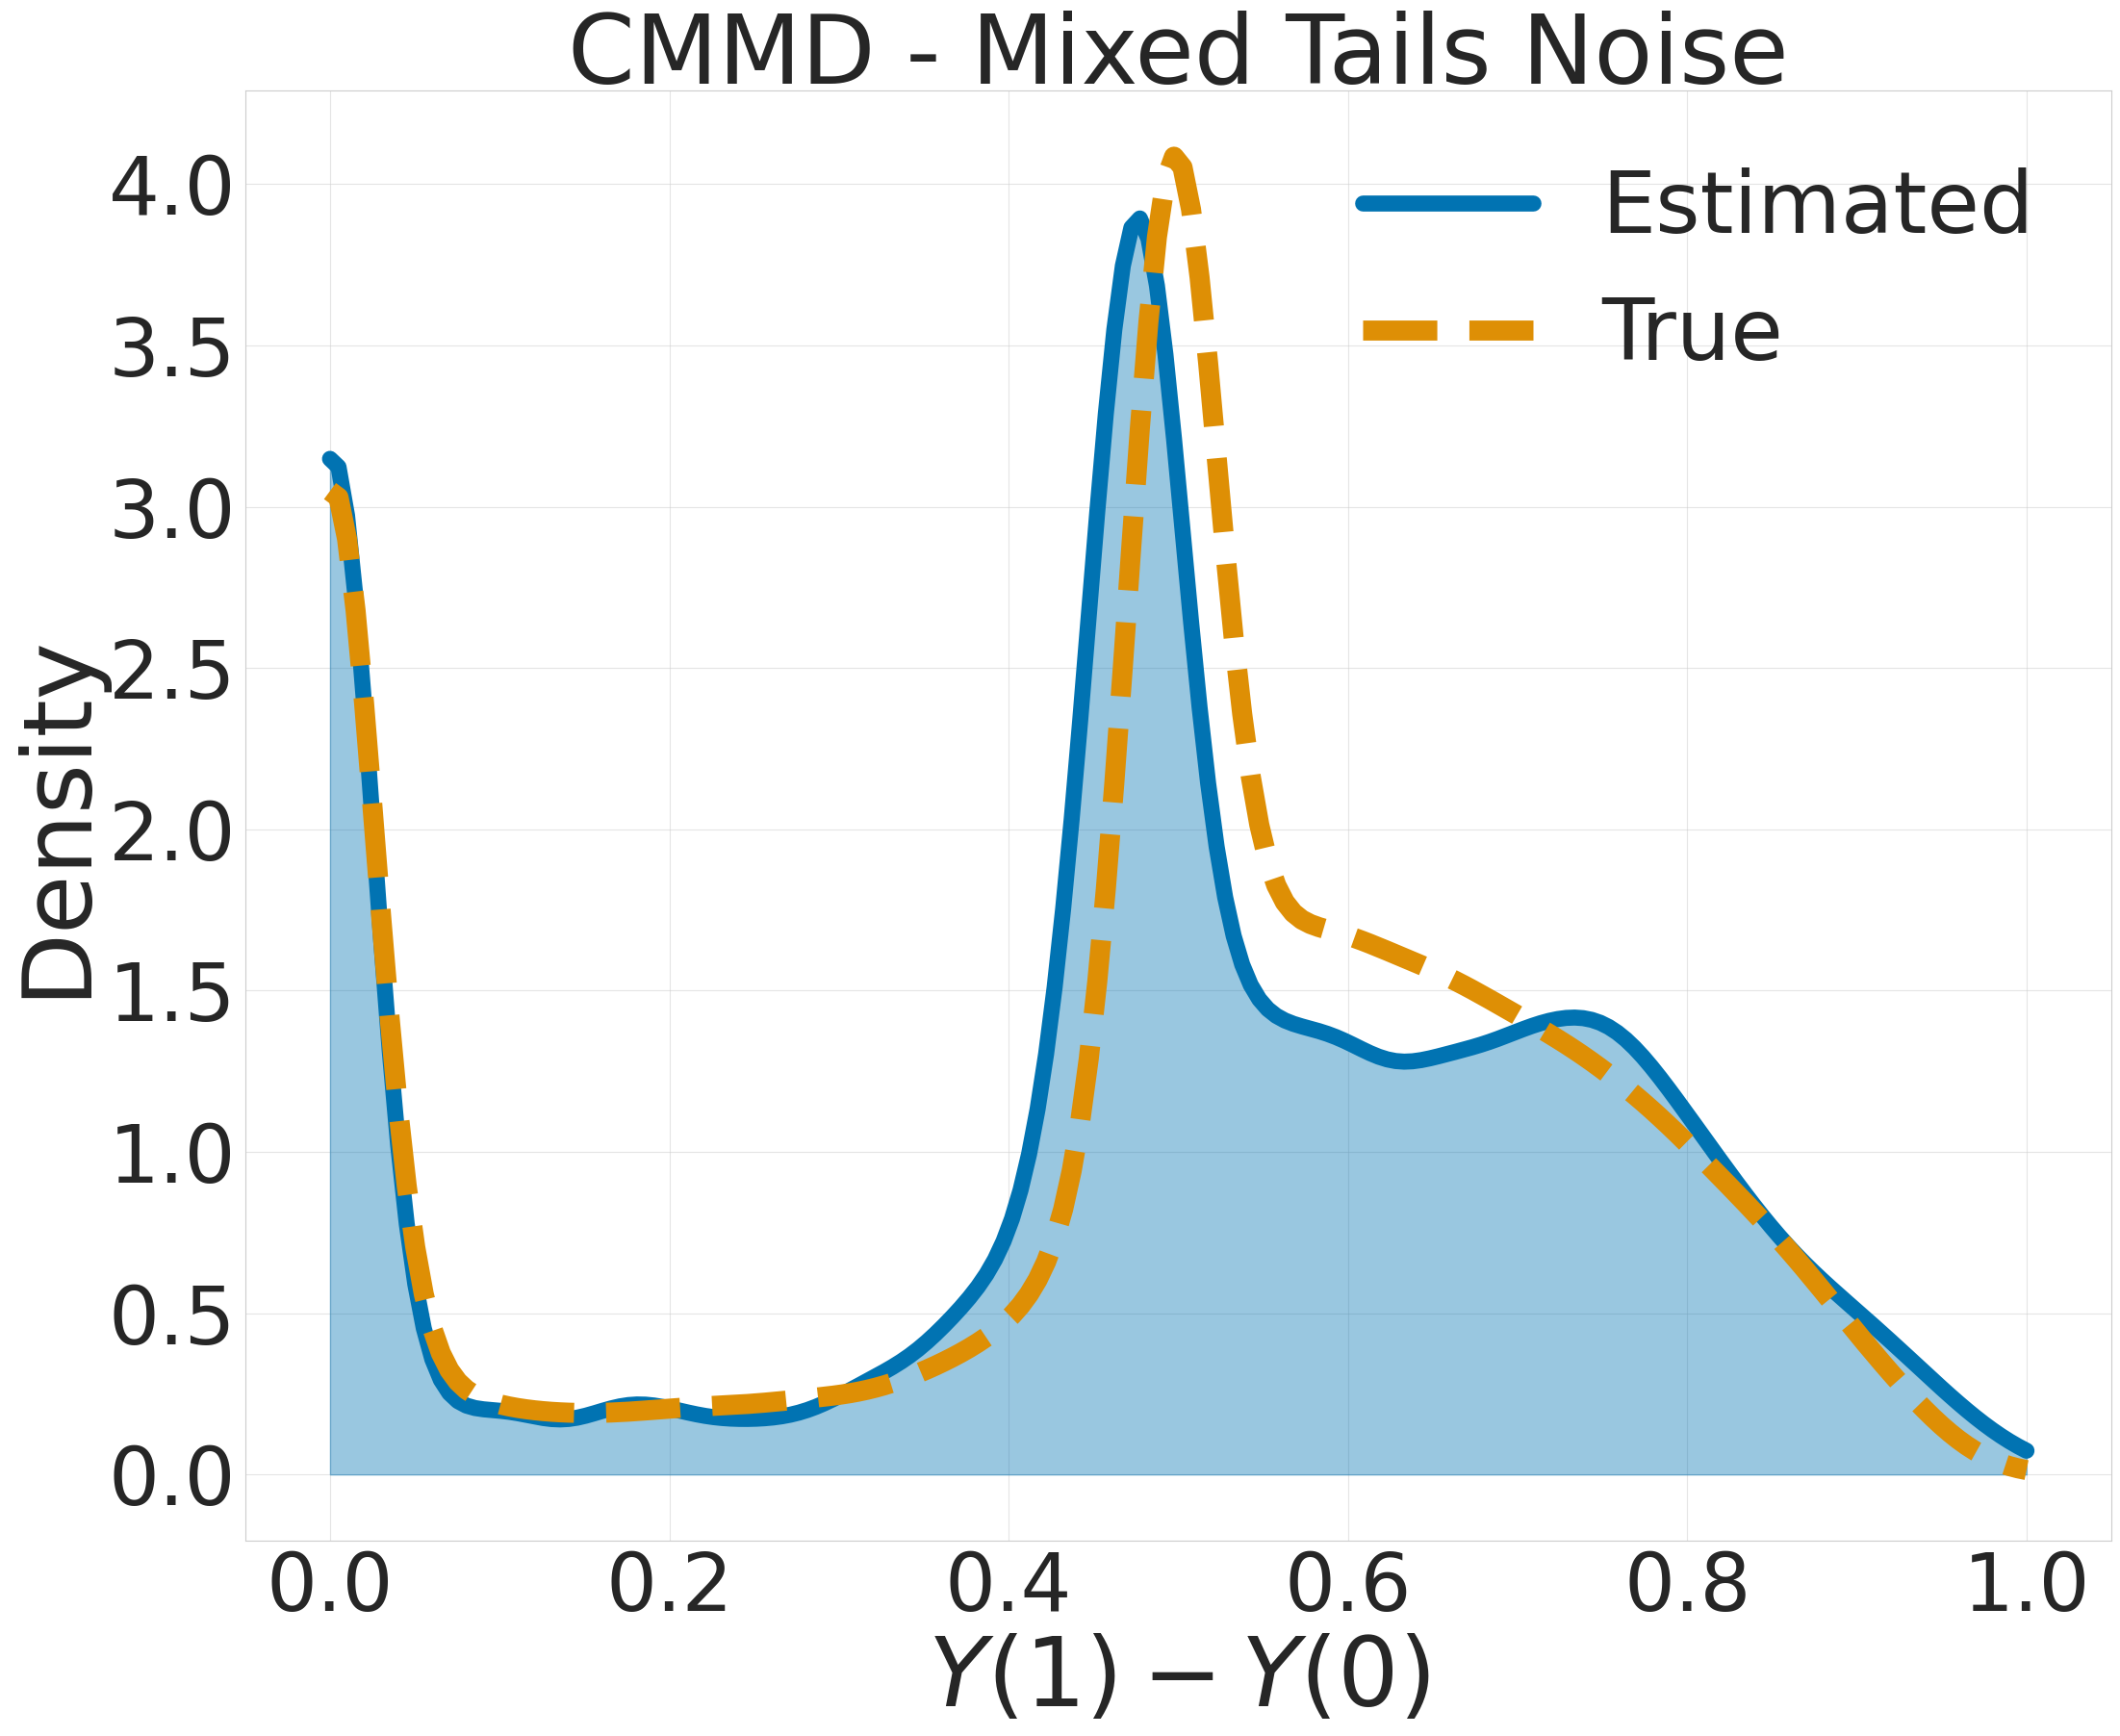

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

# ---------- aesthetics ----------
plt.rcParams.update({
    'font.size': 72,
    'axes.titlesize': 72,
    'axes.labelsize': 72,
    'xtick.labelsize': 48,
    'ytick.labelsize': 48
})
sns.set_style("whitegrid")
col_data, col_true = sns.color_palette("colorblind", 2)

# ---------- KDE estimation ----------
x_grid = np.linspace(0, 1, 200)
y_hat = ssvkernel(t(delta).numpy(), tin=x_grid, M=80, nbs=100, WinFunc='Gauss')[0]
y_true = ssvkernel(t(true_delta).numpy(), tin=x_grid, M=80, nbs=100, WinFunc='Gauss')[0]

# ---------- plot ----------
fig, ax = plt.subplots(figsize=(24, 20))  # ⬅️ doubled size

ax.plot(x_grid, y_hat, color=col_data, lw=12, label="Estimated")
ax.fill_between(x_grid, 0, y_hat, color=col_data, alpha=0.4)
ax.plot(x_grid, y_true, color=col_true, lw=15, ls="--", label="True")

# Axis labels and title with larger fontsize
ax.set_xlabel(r"$Y(1) - Y(0)$", fontsize=72)
ax.set_ylabel("Density", fontsize=72)
ax.set_title(r"CMMD - Mixed Tails Noise", fontsize=72)

# Bigger tick labels
ax.tick_params(axis='x', labelsize=60)
ax.tick_params(axis='y', labelsize=60)

# Formatting
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
ax.legend(frameon=False, fontsize=64)
ax.grid(alpha=0.5)
fig.tight_layout()
fig.savefig("cocycles_misspec_mixedtails_large.png", bbox_inches="tight")
plt.show()